### Connecting to google drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing modules:

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tkl
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Add, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from itertools import chain

### Creating a list of file names:

In [3]:
source_path = '/content/drive/MyDrive/HighResolution'
filenames = []
folder_names = ['64000', '65000', '66000', '67000', '68000']

for folder in folder_names:
    filenames.append(glob.glob(os.path.join(source_path, f'{folder}/*.png')))

filenames = list(chain.from_iterable(filenames))
random.shuffle(filenames)
print('Completed.')

Completed.


In [4]:
print(len(filenames))

5000


### Showing a sample:

/content/drive/MyDrive/HighResolution/65000/65054.png


Text(0.5, 1.0, 'Noisy')

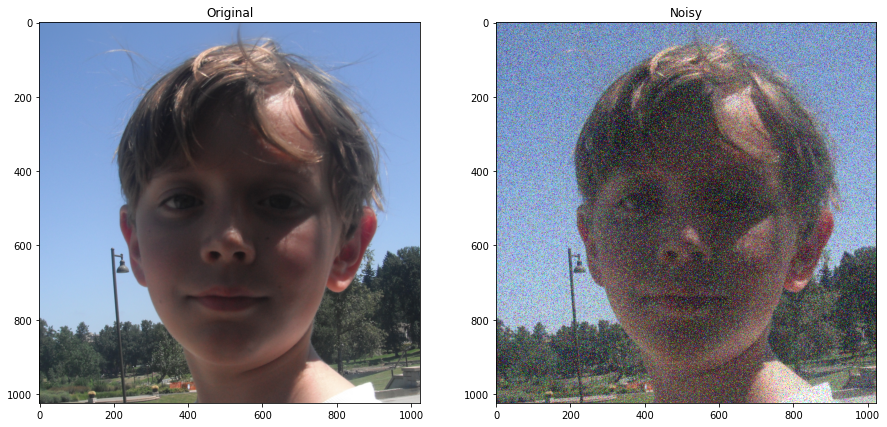

In [5]:
img_path = filenames[1000]
print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
noisy = random_noise(img, mode = 's&p', amount=0.2)
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(noisy)
ax[1].set_title('Noisy')

### Creating train set and test set:

In [6]:
test_filenames = filenames[-701:-1]
del filenames[-701:-1]
train_filenames = filenames
print(f'Size of training set is: {len(train_filenames)}', end='\n----------------------------\n')
print(f'Size of test set is: {len(test_filenames)}', end='\n----------------------------\n')

Size of training set is: 4300
----------------------------
Size of test set is: 700
----------------------------


### Train set and validation set:

In [7]:
train_img, val_img, _, _ = train_test_split(train_filenames, train_filenames, test_size = 0.1, shuffle = True, random_state = 0)

In [8]:
print(f'Size of training set is: {len(train_img)}', end='\n----------------------------\n')
print(f'Size of validation set is: {len(val_img)}', end='\n----------------------------\n')
print(f'Total: {len(train_img) + len(val_img)}')

Size of training set is: 3870
----------------------------
Size of validation set is: 430
----------------------------
Total: 4300


### Determining important variables:

In [9]:
WIDTH = 512
HEIGHT = 512
n_channels = 3
BATCH_SIZE = 16

### Data generation:

In [10]:
class  DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, original_filenames, batch_size = BATCH_SIZE, shuffle = True):
        self.original_filenames = original_filenames
        self.noisy_filenames = original_filenames
        self.filenames = list(zip(self.original_filenames, self.noisy_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle = shuffle
    
    def __len__(self):
        return (len(self.original_filenames) // self.batch_size)
    
    def __getitem__(self, idx):
        batch = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        X, Y = self.__data_generation(batch)

        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.original_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, batch):
        original = []
        noisy = []
        
        for original_filename, _ in batch:
          image = cv2.imread(original_filename) / 255
          image = cv2.resize(image, (WIDTH, HEIGHT))
          original.append(image)
          noisy.append(self.make_noisy(image))
          
        return  np.array(noisy), np.array(original)

    def make_noisy(self, image):
      image_ = image
      noisy_image = random_noise(image_, mode = 's&p', amount = 0.2)
      
      return noisy_image

### Generating training set and validation set:

In [11]:
train_generator = DataGenerator(train_img, BATCH_SIZE)
val_generator = DataGenerator(val_img, BATCH_SIZE)

### Creating the model architecture (U-net):

In [12]:
def conv_blocks_maker(inputs=None, n_filters=32, kernel_size=(3,3), padding='same'):
    
    '''First layer'''
    
    conv = tkl.Conv2D(filters = n_filters,
                      kernel_size = kernel_size,
                      padding = padding,
                      kernel_initializer = 'he_normal')(inputs)
    
    conv = tkl.Activation('relu')(conv)
    
    
    '''Second layer'''
    
    conv = tkl.Conv2D(filters = n_filters,
                     kernel_size = kernel_size,
                     padding = padding,
                     kernel_initializer = 'he_normal')(conv)
    
    conv = tkl.Activation('relu')(conv)
    
    return conv


def pool_maker(skip, pool_size=(2,2), dropout_prob=0.1):
    conv = tkl.MaxPooling2D(pool_size)(skip)
    conv = tkl.Dropout(dropout_prob)(conv)
    
    return conv


def upsampler(conv, block_size, num_filters):  
    
    """Sub-pixel convolution"""
    conv = Conv2D(num_filters * (block_size ** 2), (3,3), padding='same')(conv)
    
    """Pixel shuffle"""
    conv =  pixel_shuffle(block_size)(conv)    
    
    return conv


def pixel_shuffle(block_size):
    return lambda conv: tf.nn.depth_to_space(conv, block_size)


def decoder(conv, skip, block_size, n_filters, kernel_size, conv_blocks):
    pixel_shuffle = upsampler(conv, block_size, n_filters)
    concatenated = concatenate([skip, pixel_shuffle])
        
    if (conv_blocks == True):
        conv = conv_blocks_maker(concatenated, n_filters, kernel_size)
    else:
        conv = Conv2D(n_filters, (3,3), padding='same',
                      activation = 'relu')(concatenated)
    
    return conv

In [13]:
def unet_model_creator(n_filters=32, dropout_prob=0.1):
    
    '''Encoder part:'''
    
    input_size = (WIDTH, HEIGHT, n_channels)
    
    input_img = tf.keras.Input(input_size, name = 'image' )
    skip_1 = conv_blocks_maker(input_img, n_filters / 2, kernel_size = 3)
    
    conv = pool_maker(skip_1)
    skip_2 = conv_blocks_maker(conv, n_filters, kernel_size = 3)
    
    conv = pool_maker(skip_2)
    skip_3 = conv_blocks_maker(conv, n_filters * 2, kernel_size = 3)
    
    conv = pool_maker(skip_3)
    skip_4 = conv_blocks_maker(conv, n_filters * 4, kernel_size = 3)
    
    conv = pool_maker(skip_4)
    skip_5 = conv_blocks_maker(conv, n_filters * 8 , kernel_size = 3)
    
    conv = pool_maker(skip_5)
    conv = conv_blocks_maker(conv, n_filters * 16 , kernel_size = 3)
    

    '''Decoder part'''        
    
    decoded_layer = decoder(conv, skip_5, block_size=2,
                            n_filters=256, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_4, block_size=2,
                            n_filters=128, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_3, block_size=2,
                            n_filters=64, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_2, block_size=2,
                            n_filters=32, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_1, block_size=2,
                            n_filters=16, kernel_size=(3,3),
                            conv_blocks=False)

    output = Conv2D(3, (1,1), activation='sigmoid')(decoded_layer)

    model = tf.keras.Model(inputs = [input_img], outputs = [output])
    
    return model

In [14]:
model = unet_model_creator()

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

### Compiling the model:

In [16]:
adam = Adam(learning_rate = 0.003)
model.compile(optimizer = adam, loss = 'mse', metrics = ['accuracy'])

### Training the model:

In [17]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    use_multiprocessing = True,
                    workers = 6, epochs=20)

Epoch 1/20
241/241 [==============================] - 798s 3s/step - loss: 0.0130 - accuracy: 0.7395 - val_loss: 0.0043 - val_accuracy: 0.7810
Epoch 2/20
241/241 [==============================] - 627s 3s/step - loss: 0.0034 - accuracy: 0.8109 - val_loss: 0.0026 - val_accuracy: 0.8306
Epoch 3/20
241/241 [==============================] - 604s 2s/step - loss: 0.0025 - accuracy: 0.8361 - val_loss: 0.0023 - val_accuracy: 0.8562
Epoch 4/20
241/241 [==============================] - 596s 2s/step - loss: 0.0022 - accuracy: 0.8501 - val_loss: 0.0021 - val_accuracy: 0.8572
Epoch 5/20
241/241 [==============================] - 653s 3s/step - loss: 0.0020 - accuracy: 0.8637 - val_loss: 0.0019 - val_accuracy: 0.8683
Epoch 6/20
241/241 [==============================] - 593s 2s/step - loss: 0.0018 - accuracy: 0.8746 - val_loss: 0.0018 - val_accuracy: 0.8613
Epoch 7/20
241/241 [==============================] - 654s 3s/step - loss: 0.0017 - accuracy: 0.8802 - val_loss: 0.0019 - val_accuracy: 0.8756

### Saving the model:

In [18]:
model.save('FinalDenoiser.h5')

###Evaluating the model:

In [20]:
test_filenames = test_filenames[:100]
test_generator = DataGenerator(test_filenames, BATCH_SIZE)
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

6/6 [==============================] - 48s 9s/step - loss: 0.0012 - accuracy: 0.8898
test loss, test acc: [0.0012089451774954796, 0.8898075222969055]


###Testing the model:

In [27]:
path = test_filenames[50]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))
noisy = random_noise(img, mode = 's&p', amount=0.1)
expanded = tf.expand_dims(noisy, axis=0)
predicted = model.predict(expanded)
predicted = tf.squeeze(predicted, axis=0)

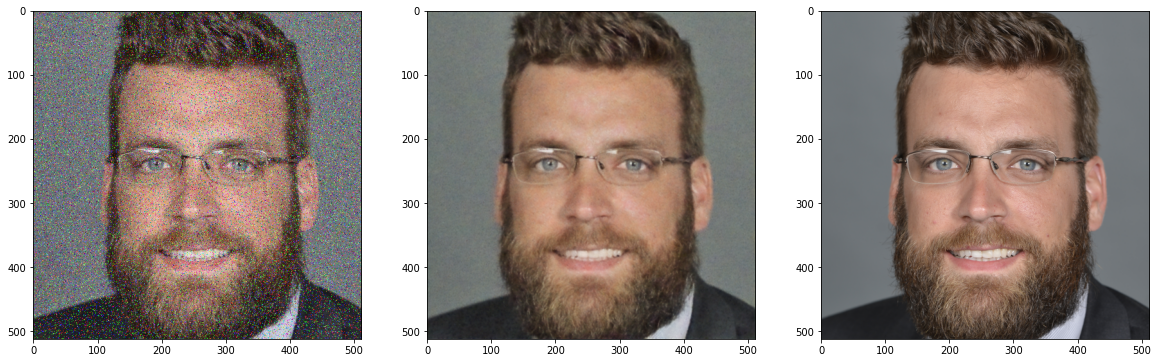

In [28]:
fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(noisy)
ax[1].imshow(predicted)
ax[2].imshow(img)